In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns

import psycopg2
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

from sqlalchemy import create_engine

from itertools import combinations
import matplotlib.pyplot as plt

from math import log

import warnings
warnings.filterwarnings("ignore")

## Cleaning the data

In [20]:
params = {
    'user': 'demidao',
    'port': 5432
}

connection = connect(**params, dbname='beer')

beer_data = pd.read_sql_table('beer_data1', connection)

In [21]:
beer_data.head()

,BeerID,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,...,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId
0,1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,...,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz,116.0
1,2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,...,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,955.0
2,3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,...,NaN,70.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN,NaN
3,4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.061,1.017,5.80,54.48,...,NaN,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,NaN
4,5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,...,1.050,72.0,NaN,Specific Gravity,All Grain,NaN,19.00,Sukkerlake,6-7 g sukker/l,18325.0


In [22]:
beer_data.shape

(73861, 23)

In [23]:
beer_data['ChangeInWort'] = beer_data['OG'] - beer_data['FG']

In [24]:
# drop columns that do not contribute to target
beer_data = beer_data.drop(columns=['BeerID','URL','StyleID','Size(L)','BrewMethod','OG','FG','SugarScale']);

#drop rows with NAs in Style and BoilGravity (about 4% of data)
beer_data = beer_data.dropna(subset=['Style','BoilGravity'])

In [25]:
#print remaining NAs
null_columns = beer_data.columns[beer_data.isnull().any()]
print(beer_data[null_columns].isnull().sum())
print('\n', '\n', beer_data.shape)

Name                 1
MashThickness    26783
PitchRate        36380
PrimaryTemp      20009
PrimingMethod    64181
PrimingAmount    66126
UserId           48163
dtype: int64

 
 (70517, 17)


In [26]:
#drop columns with NA over 30% values
beer_data = beer_data.dropna(axis=1)
beer_data.shape

(70517, 10)

I aimed to retain as much data as possible. I dropped the NA rows for Style, since missing the target value will not add to the model. I also dropped all NA rows for Boil Gravity. Dropping these rows allowed us to retain 96% of the data. There were three columns (MashThickness, PitchRate, PrimaryTemp) that were missing 1/3 - 1/2 of values. I dropped these columns since removing NA rows will reduce the total observations to 20k, causing a loss of 60% of data. Imputing the missing values will skew the data. 

## Creating Categories of Ale, Lager, and Mixed

In [27]:
# create classification row of lager or ale 
ales = ['Bitter','Fruit', 'Porter','Pale','Ale','Wheat','Stout','Belgian','IPA','Lambic','Faro','Weizenbock','Weizenbier']
lagers = ['Lager','Dunkel','Schwarzbier','Helles','Dortmunder','Traditional Bock','American','Pilsner','Pils','Doppelbock','Eisenbock','Helles Bock']
mixed = ['Kolsch','Barleywine','Altbier','Biere De Garde','Oktoberfest','Vienna','Smoked Beer','Steam Beer']

In [28]:
beer_data['MainStyle'] = np.nan

In [29]:
for ale in ales:
    beer_data.loc[beer_data.Style.str.contains(ale), 'MainStyle'] = 'Ale'
    
for lager in lagers:
    beer_data.loc[beer_data.Style.str.contains(lager), 'MainStyle'] = 'Lager'

for mix in mixed:
    beer_data.loc[beer_data.Style.str.contains(mix), 'MainStyle'] = 'Mixed'

In [157]:
null_columns = beer_data.columns[beer_data.isnull().any()]
print(beer_data[null_columns].isnull().sum())

MainStyle    13712
dtype: int64


In [39]:
# list of styles unable to classify into ale, lager, or mix
#list(beer_data[beer_data['MainStyle'].isnull()]['Style'].unique())

In [30]:
# remove data that was unable to classify
beer_data = beer_data.dropna()

In [50]:
# drop style column
beer_data = beer_data.drop('Style', axis=1)

In [32]:
beer_data.to_csv("beer_data_clean.csv")

## Exploratory Data Analysis

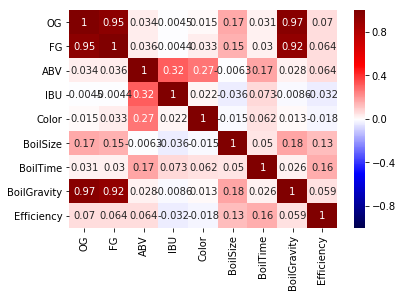

In [135]:
sns.heatmap(beer_data.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

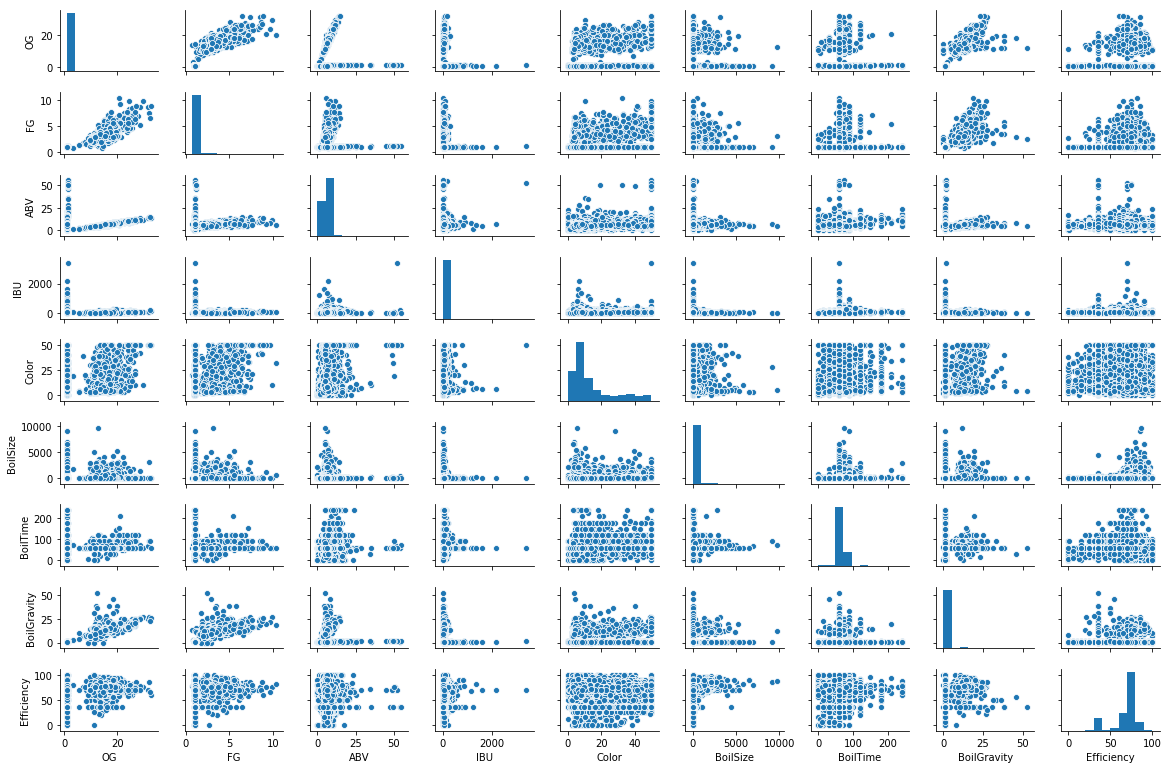

In [136]:
sns.pairplot(beer_data, height=1.2, aspect=1.5);

In [86]:
hist_columns = beer_data[['ABV', 'IBU', 'Color', 'BoilSize','BoilTime', 'BoilGravity', 'Efficiency','ChangeInWort']]

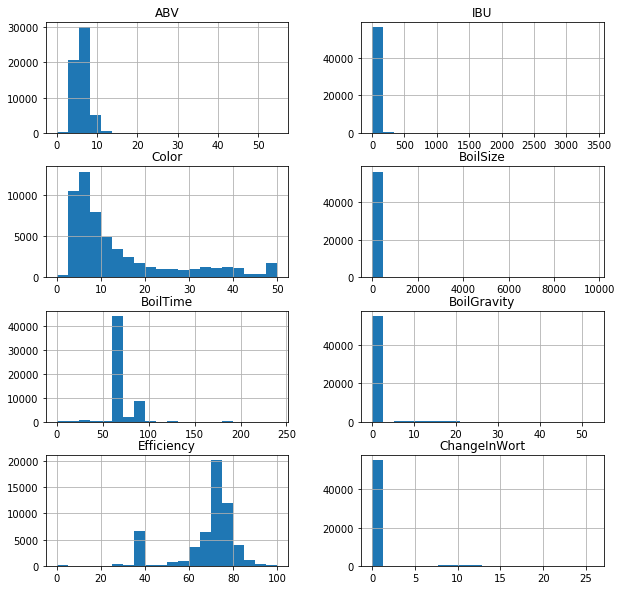

In [55]:
fig, axes = plt.subplots(len(hist_columns.columns)//2, 2, figsize=(10, 10))

i = 0

for triaxis in axes:
    for axis in triaxis:
        hist_columns.hist(column = hist_columns.columns[i], bins = 20, ax=axis)
        i = i+1

## Transforming Columns

From the graphs, it looks like some features recorded a 0.00 value.

In [69]:
# replace zeros with NaN
beer_data = beer_data.replace(0.00, np.nan)

In [71]:
null_columns = beer_data.columns[beer_data.isnull().any()]
print(beer_data[null_columns].isnull().sum())
print('\n', '\n', beer_data.shape)

ABV                4
IBU             1908
Color             25
BoilTime          75
BoilGravity        4
Efficiency        56
ChangeInWort       9
dtype: int64

 
 (56805, 9)


In [72]:
# drop nas
beer_data = beer_data.dropna(axis=0)

In [85]:
# log transform columns
beer_data['ABV'] = np.log(beer_data['ABV'])
beer_data['IBU'] = np.log(beer_data['IBU'])
beer_data['BoilGravity'] = np.log(beer_data['BoilGravity'])
beer_data['BoilSize'] = np.log(beer_data['BoilSize'])
beer_data['ChangeInWort'] = np.log(beer_data['ChangeInWort'])

Lets look at the features again

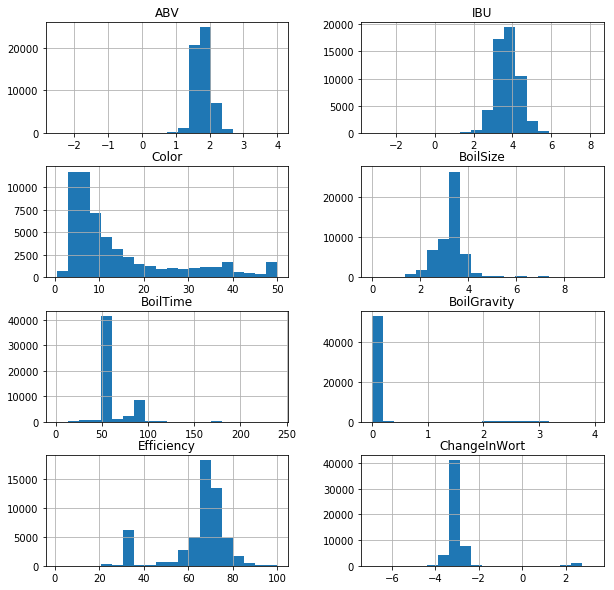

In [87]:
fig, axes = plt.subplots(len(hist_columns.columns)//2, 2, figsize=(10, 10))

i = 0

for triaxis in axes:
    for axis in triaxis:
        hist_columns.hist(column = hist_columns.columns[i], bins = 20, ax=axis)
        i = i+1

In [88]:
beer_data.to_csv("beer_data_clean_log.csv")